In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns 
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

In [2]:
engine = create_engine("sqlite:///project.db")
mta_data = pd.read_sql('SELECT * FROM project_data;', engine)

In [3]:
mta_df = pd.DataFrame(mta_data)
mta_df.head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS ...
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248


In [4]:
mta_df.drop(0, inplace=True)

In [5]:
mta_df["DATETIME"] = pd.to_datetime(mta_df["DATE"] + " " + mta_df["TIME"])

In [6]:
mta_df['MONTH'] = pd.DatetimeIndex(mta_df['DATE']).month

In [7]:
mta_df.columns = [columns.strip() for columns in mta_df.columns]

In [8]:
mta_df.drop_duplicates(subset=["CA", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

In [9]:
mta_df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (mta_df.groupby(["CA", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES", "EXITS"]
                                        .apply(lambda grp: grp.shift(1)))

<ipython-input-9-6047feee0174>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (mta_df.groupby(["CA", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES", "EXITS"]


In [10]:
mta_df.fillna(0)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,MONTH,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112,2019-02-23 03:00:00,2,0,0,0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125,2019-02-23 07:00:00,2,02/23/2019,6955483,2359112
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199,2019-02-23 11:00:00,2,02/23/2019,6955494,2359125
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248,2019-02-23 15:00:00,2,02/23/2019,6955554,2359199
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292,2019-02-23 19:00:00,2,02/23/2019,6955714,2359248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3680529,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,05:00:00,REGULAR,5554,379,2019-06-28 05:00:00,6,06/28/2019,5554,379
3680530,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,09:00:00,REGULAR,5554,379,2019-06-28 09:00:00,6,06/28/2019,5554,379
3680531,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,13:00:00,REGULAR,5554,379,2019-06-28 13:00:00,6,06/28/2019,5554,379
3680532,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,17:00:00,REGULAR,5554,379,2019-06-28 17:00:00,6,06/28/2019,5554,379


In [11]:
def hourly_entries(max_counter):
    num_entries = mta_df["ENTRIES"] - mta_df["PREV_ENTRIES"]
    num_entries = num_entries.abs()
    num_entries = num_entries.apply(lambda x: 0 if x>max_counter else x)
    return num_entries

In [12]:
mta_df["DAILY_ENTRIES"] = hourly_entries(max_counter=15000)

In [13]:
def hourly_exits(max_counter):
    num_exits = mta_df["EXITS"] - mta_df["PREV_EXITS"]
    num_exits = num_exits.abs()
    num_exits = num_exits.apply(lambda x: 0 if x>max_counter else x)
    return num_exits

In [14]:
mta_df["DAILY_EXITS"] = hourly_exits(max_counter=100000)

In [15]:
def time_convert(input): #convert timestamp 
    return int(input.replace(':', "")[0:2])

In [16]:
mta_df["HOUR"] = mta_df["TIME"].apply(time_convert)

In [17]:
def time_buckets(num):
    if num >= 2 and num < 6:
        return 'midnight to 4am'
    elif num >= 6 and num < 10:
        return '4am to 8am'
    elif num >= 10 and num < 14:
         return '8am to noon'
    elif num >= 14 and num < 18:
         return 'noon to 4pm'
    elif num >= 18 and num < 22:
        return '4pm to 8pm'
    elif num >= 22 or num < 2:
        return '8pm to midnight'
    else:
        return "xyz"

In [18]:
mta_df["TIME_BUCKET"] = mta_df["HOUR"].apply(time_buckets)

In [19]:
mta_df["INTERVAL_TOTAL_TRAFFIC"] = mta_df["DAILY_ENTRIES"] + mta_df["DAILY_EXITS"]

In [20]:
mta_df.drop(mta_df.loc[mta_df['MONTH']==2].index, inplace=True) #dropping feb

In [21]:
mta_df

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DATETIME,MONTH,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,HOUR,TIME_BUCKET,INTERVAL_TOTAL_TRAFFIC
37,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/01/2019,03:00:00,REGULAR,6962094,...,2019-03-01 03:00:00,3,02/28/2019,6962053,2361664,41.0,8.0,3,midnight to 4am,49.0
38,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/01/2019,07:00:00,REGULAR,6962111,...,2019-03-01 07:00:00,3,03/01/2019,6962094,2361672,17.0,42.0,7,4am to 8am,59.0
39,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/01/2019,11:00:00,REGULAR,6962243,...,2019-03-01 11:00:00,3,03/01/2019,6962111,2361714,132.0,303.0,11,8am to noon,435.0
40,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/01/2019,15:00:00,REGULAR,6962502,...,2019-03-01 15:00:00,3,03/01/2019,6962243,2362017,259.0,65.0,15,noon to 4pm,324.0
41,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/01/2019,19:00:00,REGULAR,6963303,...,2019-03-01 19:00:00,3,03/01/2019,6962502,2362082,801.0,67.0,19,4pm to 8pm,868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3680529,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,05:00:00,REGULAR,5554,...,2019-06-28 05:00:00,6,06/28/2019,5554,379,0.0,0.0,5,midnight to 4am,0.0
3680530,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,09:00:00,REGULAR,5554,...,2019-06-28 09:00:00,6,06/28/2019,5554,379,0.0,0.0,9,4am to 8am,0.0
3680531,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,13:00:00,REGULAR,5554,...,2019-06-28 13:00:00,6,06/28/2019,5554,379,0.0,0.0,13,8am to noon,0.0
3680532,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/28/2019,17:00:00,REGULAR,5554,...,2019-06-28 17:00:00,6,06/28/2019,5554,379,0.0,0.0,17,noon to 4pm,0.0


In [68]:
mask = ((mta_df["CA"] == "R405") & 
(mta_df["UNIT"] == "R447") & 
(mta_df["STATION"] == "CYPRESS AV") &
(mta_df["SCP"] == "01-00-00") &
(mta_df["DATE"] == "04/18/2019"))

mta_df[mask]

,STATION,TIME,HOUR,TIME_BUCKET
1598484,CYPRESS AV,01:00:00,1,8pm to midnight
1598485,CYPRESS AV,13:00:00,13,8am to noon
1598486,CYPRESS AV,17:00:00,17,noon to 4pm
1598487,CYPRESS AV,21:00:00,21,4pm to 8pm


In [70]:
mask2 = ((mta_df["STATION"] == "FRANKLIN ST"))
mta_df[mask2][["STATION", "TIME", "HOUR", "TIME_BUCKET"]]

,STATION,TIME,HOUR,TIME_BUCKET
131193,FRANKLIN ST,00:00:00,0,8pm to midnight
131194,FRANKLIN ST,04:00:00,4,midnight to 4am
131195,FRANKLIN ST,08:00:00,8,4am to 8am
131196,FRANKLIN ST,12:00:00,12,8am to noon
131197,FRANKLIN ST,16:00:00,16,noon to 4pm
...,...,...,...,...
3607527,FRANKLIN ST,05:00:00,5,midnight to 4am
3607528,FRANKLIN ST,09:00:00,9,4am to 8am
3607529,FRANKLIN ST,13:00:00,13,8am to noon
3607530,FRANKLIN ST,17:00:00,17,noon to 4pm


In [23]:
time_interval_traffic = mta_df[((mta_df['STATION'] =='34 ST-PENN STA') | (mta_df['STATION'] == 'GRD CNTRL-42 ST') | 
               (mta_df['STATION'] == '34 ST-HERALD SQ') | (mta_df['STATION'] == '14 ST-UNION SQ') | 
               (mta_df['STATION'] =='TIMES SQ-42 ST') | (mta_df['STATION'] == '23 ST') | 
               (mta_df['STATION'] == '42 ST-PORT AUTH') | (mta_df['STATION'] == 'FULTON ST') | 
               (mta_df['STATION'] =='86 ST') | (mta_df['STATION'] == '125 ST') | 
               (mta_df['STATION'] == 'CANAL ST'))].groupby(["TIME_BUCKET"]).INTERVAL_TOTAL_TRAFFIC.sum()

In [24]:
time_interval_traffic = time_interval_traffic.to_frame().reset_index().sort_values(by="INTERVAL_TOTAL_TRAFFIC", ascending=False)

In [25]:
time_interval_traffic #total traffic per time interval

,TIME_BUCKET,INTERVAL_TOTAL_TRAFFIC
1,4pm to 8pm,75215949.0
2,8am to noon,55074402.0
5,noon to 4pm,51740650.0
3,8pm to midnight,27651015.0
0,4am to 8am,25063801.0
4,midnight to 4am,4938946.0


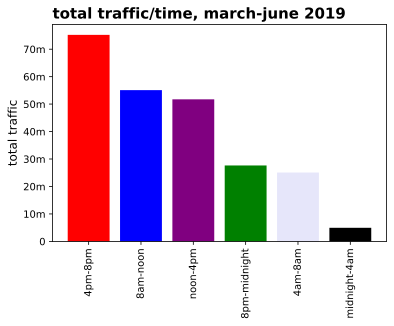

In [65]:
plt.bar(x=time_interval_traffic['TIME_BUCKET'], height=time_interval_traffic['INTERVAL_TOTAL_TRAFFIC'], 
       color=['red', 'blue', 'purple', 'green', 'lavender', 'black'])
plt.title("total traffic/time, march-june 2019", fontsize=15, weight="bold", loc="left")
plt.ylabel('total traffic', fontsize=12)

plt.xticks(rotation=90)
ticks_x = ["4pm to 8pm", "8am to noon", "noon to 4pm", "8pm to midnight", "4am to 8am", "midnight to 4am"]
label_x = ["4pm-8pm", "8am-noon", "noon-4pm", "8pm-midnight", "4am-8am", "midnight-4am" ]
plt.xticks(ticks_x, label_x);
ticks_y = [0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000]
label_y = ["0","10m", "20m", "30m", "40m", "50m", "60m", "70m"]
plt.yticks(ticks_y, label_y);

plt.savefig('traffictimebar.png', bbox_inches="tight")

In [27]:
time_interval_traffic_station = mta_df.groupby(["STATION", "TIME_BUCKET"]).INTERVAL_TOTAL_TRAFFIC.sum()

In [28]:
time_interval_traffic_station = time_interval_traffic_station.to_frame().reset_index()

In [29]:
time_interval_traffic_station #total traffic per station per time interval

,STATION,TIME_BUCKET,INTERVAL_TOTAL_TRAFFIC
0,1 AV,4am to 8am,402351.0
1,1 AV,4pm to 8pm,1229892.0
2,1 AV,8am to noon,896375.0
3,1 AV,8pm to midnight,576962.0
4,1 AV,midnight to 4am,76499.0
...,...,...,...
2269,ZEREGA AV,4pm to 8pm,114077.0
2270,ZEREGA AV,8am to noon,89565.0
2271,ZEREGA AV,8pm to midnight,39795.0
2272,ZEREGA AV,midnight to 4am,15038.0


In [30]:
time_interval_traffic_station['TIME_BUCKET'] = pd.Categorical(time_interval_traffic_station['TIME_BUCKET'],
                             categories=['midnight to 4am', '4am to 8am', '8am to noon', \
                             'noon to 4pm', '4pm to 8pm', '8pm to midnight'],ordered=True)

<ipython-input-31-63794e18ba0d>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  time_plot.set(yticklabels=["0", "0", "2m", "4m", "6m", "8m", "10m"])
<ipython-input-31-63794e18ba0d>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  station_time_plot.set(yticklabels=["0", "0.5m", "1m", "1.5m", "2m", "2.5m", "3m", "3.5m", "4m"]);


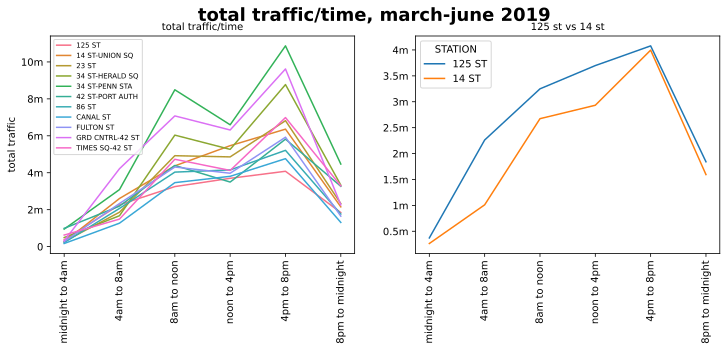

In [31]:
plt.figure(figsize=[12,4])
plt.suptitle('total traffic/time, march-june 2019',fontsize = 18, weight="bold")

plt.subplot(1,2,1)
time_plot = sns.lineplot(x='TIME_BUCKET', y='INTERVAL_TOTAL_TRAFFIC', hue='STATION', 
             data=time_interval_traffic_station[((time_interval_traffic_station['STATION'] =='34 ST-PENN STA') | (time_interval_traffic_station['STATION'] == 'GRD CNTRL-42 ST') | 
               (time_interval_traffic_station['STATION'] == '34 ST-HERALD SQ') | (time_interval_traffic_station['STATION'] == '14 ST-UNION SQ') | 
               (time_interval_traffic_station['STATION'] =='TIMES SQ-42 ST') | (time_interval_traffic_station['STATION'] == '23 ST') | 
               (time_interval_traffic_station['STATION'] == '42 ST-PORT AUTH') | (time_interval_traffic_station['STATION'] == 'FULTON ST') | 
               (time_interval_traffic_station['STATION'] =='86 ST') | (time_interval_traffic_station['STATION'] == '125 ST') | 
               (time_interval_traffic_station['STATION'] == 'CANAL ST'))])
sns.color_palette("colorblind")
plt.legend(loc="best", prop={'size': 7})

time_plot.set(xlabel=None)
plt.ylabel('total traffic')
plt.xticks(rotation=90)
time_plot.set(yticklabels=["0", "0", "2m", "4m", "6m", "8m", "10m"])
plt.title('total traffic/time', fontsize=10)

plt.subplot(1,2,2)
station_time_plot = sns.lineplot(x='TIME_BUCKET', y='INTERVAL_TOTAL_TRAFFIC', hue='STATION', 
             data=time_interval_traffic_station[((time_interval_traffic_station['STATION'] == '125 ST') | 
               (time_interval_traffic_station['STATION'] == '14 ST'))])

plt.title("125 st vs 14 st", fontsize=10)
station_time_plot.set(xlabel=None)
station_time_plot.set(ylabel=None)
plt.xticks(rotation=90)
station_time_plot.set(yticklabels=["0", "0.5m", "1m", "1.5m", "2m", "2.5m", "3m", "3.5m", "4m"]);

plt.savefig('traffictimesubplot.png', bbox_inches="tight")

In [32]:
#time_plot = sns.lineplot(x='TIME_BUCKET', y='INTERVAL_TOTAL_TRAFFIC', hue='STATION', 
             #data=time_interval_traffic_station[((time_interval_traffic_station['STATION'] =='34 ST-PENN STA') | (time_interval_traffic_station['STATION'] == 'GRD CNTRL-42 ST') | 
               #(time_interval_traffic_station['STATION'] == '34 ST-HERALD SQ') | (time_interval_traffic_station['STATION'] == '14 ST-UNION SQ') | 
               #(time_interval_traffic_station['STATION'] =='TIMES SQ-42 ST') | (time_interval_traffic_station['STATION'] == '23 ST') | 
               #(time_interval_traffic_station['STATION'] == '42 ST-PORT AUTH') | (time_interval_traffic_station['STATION'] == 'FULTON ST') | 
               #(time_interval_traffic_station['STATION'] =='86 ST') | (time_interval_traffic_station['STATION'] == '125 ST') | 
               #(time_interval_traffic_station['STATION'] == 'CANAL ST'))])
#sns.color_palette("colorblind")
#plt.title("total traffic/time, march-june 2019", fontsize=15, weight="bold", loc="left")
#plt.xlabel('time intervals', fontsize=12)
#plt.ylabel('total traffic', fontsize=12)
#plt.legend(loc=3, prop={'size': 7})

#plt.xticks(rotation=30)
#time_plot.set(yticklabels=["0", "0", "2m", "4m", "6m", "8m", "10m"]);


In [33]:
#station_time_plot = sns.lineplot(x='TIME_BUCKET', y='INTERVAL_TOTAL_TRAFFIC', hue='STATION', 
            # data=time_interval_traffic_station[((time_interval_traffic_station['STATION'] == '125 ST') | 
               #(time_interval_traffic_station['STATION'] == '14 ST'))])

#plt.title("total traffic/time, 125 st vs 14 st", fontsize=20, weight="bold", loc="left")
#plt.xlabel('time intervals')
#plt.ylabel('total number of traffic')
#plt.xticks(rotation=20)
#station_time_plot.set(yticklabels=["0", "0.5m", "1m", "1.5m", "2m", "2.5m", "3m", "3.5m", "4m"])
#plt.figure(figsize=(15,4));

In [34]:
mta_entries = mta_df.groupby(['CA','UNIT','SCP','STATION','DATE']).DAILY_ENTRIES.sum() 
mta_exits = mta_df.groupby(['CA','UNIT','SCP','STATION','DATE']).DAILY_EXITS.sum() 

In [35]:
mta_entries_flatten = mta_entries.reset_index()
mta_exits_flatten = mta_exits.reset_index()

In [36]:
mta_entries_exits = pd.merge(mta_entries_flatten, mta_exits_flatten, how='outer')

In [37]:
mta_entries_exits['TOTAL_TRAFFIC'] = mta_entries_exits['DAILY_ENTRIES'] + mta_entries_exits['DAILY_EXITS']
mta_entries_exits["DAY_OF_WEEK"] = pd.to_datetime(mta_entries_exits["DATE"]).dt.day_name()
mta_entries_exits["DAY_INDEXED"] = pd.to_datetime(mta_entries_exits["DATE"]).dt.weekday
mta_entries_exits['WEEK_OF_YEAR'] = pd.to_datetime(mta_entries_exits['DATE']).dt.week
mta_entries_exits['MONTH'] = pd.DatetimeIndex(mta_entries_exits['DATE']).month

<ipython-input-37-9a9b87bcd107>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  mta_entries_exits['WEEK_OF_YEAR'] = pd.to_datetime(mta_entries_exits['DATE']).dt.week


In [38]:
mta_entries_exits #grouped by turnstiles

,CA,UNIT,SCP,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,TOTAL_TRAFFIC,DAY_OF_WEEK,DAY_INDEXED,WEEK_OF_YEAR,MONTH
0,A002,R051,02-00-00,59 ST,03/01/2019,1525.0,532.0,2057.0,Friday,4,9,3
1,A002,R051,02-00-00,59 ST,03/02/2019,742.0,207.0,949.0,Saturday,5,9,3
2,A002,R051,02-00-00,59 ST,03/03/2019,568.0,179.0,747.0,Sunday,6,9,3
3,A002,R051,02-00-00,59 ST,03/04/2019,1235.0,395.0,1630.0,Monday,0,10,3
4,A002,R051,02-00-00,59 ST,03/05/2019,1479.0,475.0,1954.0,Tuesday,1,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...
580722,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/24/2019,0.0,0.0,0.0,Monday,0,26,6
580723,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/25/2019,0.0,0.0,0.0,Tuesday,1,26,6
580724,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/26/2019,0.0,0.0,0.0,Wednesday,2,26,6
580725,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/27/2019,0.0,0.0,0.0,Thursday,3,26,6


In [39]:
(mta_entries_exits.DAILY_ENTRIES > 50000).value_counts

<bound method IndexOpsMixin.value_counts of 0         False
1         False
2         False
3         False
4         False
          ...  
580722    False
580723    False
580724    False
580725    False
580726    False
Name: DAILY_ENTRIES, Length: 580727, dtype: bool>

In [40]:
station_daily = mta_entries_exits.groupby(["STATION", "DATE"])[['TOTAL_TRAFFIC']].sum().reset_index()

In [41]:
station_daily["DAY_OF_WEEK"] = pd.to_datetime(station_daily["DATE"]).dt.day_name()
station_daily['WEEK_OF_YEAR'] = pd.to_datetime(station_daily['DATE']).dt.week
station_daily['MONTH'] = pd.DatetimeIndex(station_daily['DATE']).month

<ipython-input-41-190fe1d9b28b>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  station_daily['WEEK_OF_YEAR'] = pd.to_datetime(station_daily['DATE']).dt.week


In [42]:
station_daily #grouped by station, by day

,STATION,DATE,TOTAL_TRAFFIC,DAY_OF_WEEK,WEEK_OF_YEAR,MONTH
0,1 AV,03/01/2019,45079.0,Friday,9,3
1,1 AV,03/02/2019,463.0,Saturday,9,3
2,1 AV,03/03/2019,57.0,Sunday,9,3
3,1 AV,03/04/2019,31433.0,Monday,10,3
4,1 AV,03/05/2019,42313.0,Tuesday,10,3
...,...,...,...,...,...,...
45256,ZEREGA AV,06/24/2019,5236.0,Monday,26,6
45257,ZEREGA AV,06/25/2019,5128.0,Tuesday,26,6
45258,ZEREGA AV,06/26/2019,5590.0,Wednesday,26,6
45259,ZEREGA AV,06/27/2019,5203.0,Thursday,26,6


In [43]:
station_daily[station_daily["STATION"] == "CYPRESS AV"]

,STATION,DATE,TOTAL_TRAFFIC,DAY_OF_WEEK,WEEK_OF_YEAR,MONTH
23513,CYPRESS AV,03/01/2019,6594.0,Friday,9,3
23514,CYPRESS AV,03/02/2019,3564.0,Saturday,9,3
23515,CYPRESS AV,03/03/2019,2717.0,Sunday,9,3
23516,CYPRESS AV,03/04/2019,4930.0,Monday,10,3
23517,CYPRESS AV,03/05/2019,6422.0,Tuesday,10,3
...,...,...,...,...,...,...
23628,CYPRESS AV,06/24/2019,6097.0,Monday,26,6
23629,CYPRESS AV,06/25/2019,6114.0,Tuesday,26,6
23630,CYPRESS AV,06/26/2019,6364.0,Wednesday,26,6
23631,CYPRESS AV,06/27/2019,6234.0,Thursday,26,6


In [44]:
station_monthly = station_daily.groupby(["STATION", "MONTH"])[['TOTAL_TRAFFIC']].sum().reset_index()

In [45]:
station_monthly #grouped by station, monthly basis

,STATION,MONTH,TOTAL_TRAFFIC
0,1 AV,3,987344.0
1,1 AV,4,1109113.0
2,1 AV,5,1014105.0
3,1 AV,6,900028.0
4,103 ST,3,1398834.0
...,...,...,...
1506,YORK ST,6,499282.0
1507,ZEREGA AV,3,133677.0
1508,ZEREGA AV,4,132467.0
1509,ZEREGA AV,5,137564.0


In [46]:
station_daily[((station_daily['STATION'] =='34 ST-PENN STA') | (station_daily['STATION'] == 'GRD CNTRL-42 ST') | 
               (station_daily['STATION'] == '34 ST-HERALD SQ') | (station_daily['STATION'] == '14 ST-UNION SQ') | 
               (station_daily['STATION'] =='TIMES SQ-42 ST') | (station_daily['STATION'] == '23 ST') | 
               (station_daily['STATION'] == '42 ST-PORT AUTH') | (station_daily['STATION'] == 'FULTON ST') | 
               (station_daily['STATION'] =='86 ST') | (station_daily['STATION'] == '125 ST') | 
               (station_daily['STATION'] == 'CANAL ST'))]

,STATION,DATE,TOTAL_TRAFFIC,DAY_OF_WEEK,WEEK_OF_YEAR,MONTH
1079,125 ST,03/01/2019,146309.0,Friday,9,3
1080,125 ST,03/02/2019,92920.0,Saturday,9,3
1081,125 ST,03/03/2019,79066.0,Sunday,9,3
1082,125 ST,03/04/2019,105194.0,Monday,10,3
1083,125 ST,03/05/2019,144338.0,Tuesday,10,3
...,...,...,...,...,...,...
42256,TIMES SQ-42 ST,06/24/2019,192700.0,Monday,26,6
42257,TIMES SQ-42 ST,06/25/2019,202468.0,Tuesday,26,6
42258,TIMES SQ-42 ST,06/26/2019,216549.0,Wednesday,26,6
42259,TIMES SQ-42 ST,06/27/2019,217181.0,Thursday,26,6


In [47]:
total_per_day = station_daily.groupby(["STATION", "DAY_OF_WEEK"])["TOTAL_TRAFFIC"].sum().reset_index()

In [48]:
total_per_day #grouped by station, total traffic per day

,STATION,DAY_OF_WEEK,TOTAL_TRAFFIC
0,1 AV,Friday,759758.0
1,1 AV,Monday,587938.0
2,1 AV,Saturday,331767.0
3,1 AV,Sunday,250350.0
4,1 AV,Thursday,702865.0
...,...,...,...
2648,ZEREGA AV,Saturday,45561.0
2649,ZEREGA AV,Sunday,34457.0
2650,ZEREGA AV,Thursday,90860.0
2651,ZEREGA AV,Tuesday,89988.0


In [49]:
total_per_day['DAY_OF_WEEK'] = pd.Categorical(total_per_day['DAY_OF_WEEK'],
                                   categories=['Monday', 'Tuesday', "Wednesday", 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

<ipython-input-50-362918f0b217>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  day_plot.set(yticklabels=["0", "0", "1m", "2m", "3m", "4m", "5m", "6m"])
<ipython-input-50-362918f0b217>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  day_plot.set(xticklabels=["M", "T", "W", "Th", "F", "Sa", "Su"])
<ipython-input-50-362918f0b217>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  station_day_plot.set(yticklabels=["0", "0", "1m", "1.5m", "2m", "2.5m", "3m", "3.5m"])
<ipython-input-50-362918f0b217>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  station_day_plot.set(xticklabels=["M", "T", "W", "Th", "F", "Sa", "Su"])


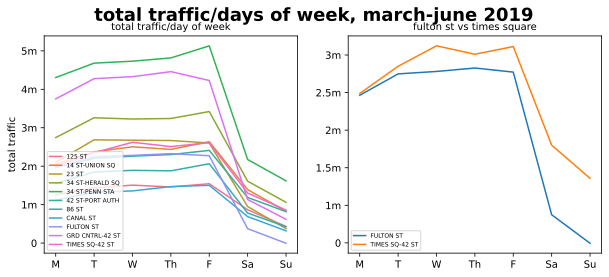

In [50]:
plt.figure(figsize=[10,4])
plt.suptitle('total traffic/days of week, march-june 2019',fontsize = 18, weight="bold")

plt.subplot(1,2,1)
day_plot = sns.lineplot(x='DAY_OF_WEEK', y='TOTAL_TRAFFIC', hue='STATION', 
             data=total_per_day[((total_per_day['STATION'] =='34 ST-PENN STA') | (total_per_day['STATION'] == 'GRD CNTRL-42 ST') | 
               (total_per_day['STATION'] == '34 ST-HERALD SQ') | (total_per_day['STATION'] == '14 ST-UNION SQ') | 
               (total_per_day['STATION'] =='TIMES SQ-42 ST') | (total_per_day['STATION'] == '23 ST') | 
               (total_per_day['STATION'] == '42 ST-PORT AUTH') | (total_per_day['STATION'] == 'FULTON ST') | 
               (total_per_day['STATION'] =='86 ST') | (total_per_day['STATION'] == '125 ST') | 
               (total_per_day['STATION'] == 'CANAL ST'))])

plt.title("total traffic/day of week", fontsize=10)
day_plot.set(xlabel=None)
plt.ylabel('total traffic')
plt.legend(loc=3, prop={'size': 6})
day_plot.set(yticklabels=["0", "0", "1m", "2m", "3m", "4m", "5m", "6m"])
day_plot.set(xticklabels=["M", "T", "W", "Th", "F", "Sa", "Su"])


plt.subplot(1,2,2)
station_day_plot = sns.lineplot(x='DAY_OF_WEEK', y='TOTAL_TRAFFIC', hue='STATION', 
             data=total_per_day[((total_per_day['STATION'] =='TIMES SQ-42 ST') | 
                                 (total_per_day['STATION'] == 'FULTON ST'))])

plt.title("fulton st vs times square", fontsize=10)
station_day_plot.set(xlabel=None)
station_day_plot.set(ylabel=None)
station_day_plot.set(yticklabels=["0", "0", "1m", "1.5m", "2m", "2.5m", "3m", "3.5m"])
station_day_plot.set(xticklabels=["M", "T", "W", "Th", "F", "Sa", "Su"])
plt.legend(loc=3, prop={'size': 6});

plt.savefig('trafficdaysubplot.png', bbox_inches="tight")

In [51]:
#sns.lineplot(x='DAY_OF_WEEK', y='TOTAL_TRAFFIC', hue='STATION', 
             #data=total_per_day[((total_per_day['STATION'] =='34 ST-PENN STA') | (total_per_day['STATION'] == 'GRD CNTRL-42 ST') | 
              # (total_per_day['STATION'] == '34 ST-HERALD SQ') | (total_per_day['STATION'] == '14 ST-UNION SQ') | 
              # (total_per_day['STATION'] =='TIMES SQ-42 ST') | (total_per_day['STATION'] == '23 ST') | 
              # (total_per_day['STATION'] == '42 ST-PORT AUTH') | (total_per_day['STATION'] == 'FULTON ST') | 
              # (total_per_day['STATION'] =='86 ST') | (total_per_day['STATION'] == '125 ST') | 
              # (total_per_day['STATION'] == 'CANAL ST'))])

#plt.title("total traffic/day for top 10 stations, march-june 2019", fontsize=20, weight="bold", loc="left")
#plt.xlabel('days of week')
#plt.ylabel('total number of traffic')
#plt.legend(loc=3, prop={'size': 6})
#plt.xticks(rotation=45)
#plt.figure(figsize=(25,5))

#plt.savefig('trafficperdayline.png')


In [52]:
#sns.lineplot(x='DAY_OF_WEEK', y='TOTAL_TRAFFIC', hue='STATION', 
            # data=total_per_day[((total_per_day['STATION'] =='TIMES SQ-42 ST') | 
                                # (total_per_day['STATION'] == 'FULTON ST'))])

#plt.title("total traffic/day for top 10 stations, march-june 2019", fontsize=20, weight="bold", loc="left")
#plt.xlabel('days of week')
#plt.ylabel('total number of traffic')
#plt.legend(loc=3, prop={'size': 6})
#plt.xticks(rotation=45)
#plt.figure(figsize=(25,5))


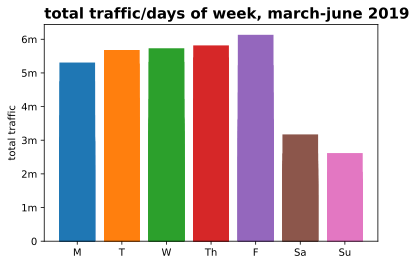

In [67]:
for i, group in total_per_day[((total_per_day['STATION'] =='34 ST-PENN STA') | (total_per_day['STATION'] == 'GRD CNTRL-42 ST') | 
               (total_per_day['STATION'] == '34 ST-HERALD SQ') | (total_per_day['STATION'] == '14 ST-UNION SQ') | 
               (total_per_day['STATION'] =='TIMES SQ-42 ST') | (total_per_day['STATION'] == '23 ST') | 
               (total_per_day['STATION'] == '42 ST-PORT AUTH') | (total_per_day['STATION'] == 'FULTON ST') | 
               (total_per_day['STATION'] =='86 ST') | (total_per_day['STATION'] == '125 ST') | 
               (total_per_day['STATION'] == 'CANAL ST'))].groupby('DAY_OF_WEEK'):
    plt.bar(group['DAY_OF_WEEK'], group['TOTAL_TRAFFIC'])
    
plt.title("total traffic/days of week, march-june 2019", fontsize=15, weight="bold", loc="left")
plt.ylabel('total traffic')


ticks_x = ['Monday', 'Tuesday', "Wednesday", 'Thursday', 'Friday', 'Saturday', 'Sunday']
label_x = ["M", "T", "W", "Th", "F", "Sa", "Su"]
plt.xticks(ticks_x, label_x);
ticks_y = [0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000]
label_y = ["0","1m", "2m", "3m", "4m", "5m", "6m"]
plt.yticks(ticks_y, label_y);
plt.savefig('trafficdaybar.png', bbox_inches="tight")

In [54]:
station_totals = station_monthly.groupby('STATION').sum()\
    .sort_values('TOTAL_TRAFFIC', ascending=False)\
    .reset_index()

station_totals.head(10)

,STATION,MONTH,TOTAL_TRAFFIC
0,34 ST-PENN STA,18,34459764.0
1,GRD CNTRL-42 ST,18,29798151.0
2,34 ST-HERALD SQ,18,25563903.0
3,TIMES SQ-42 ST,18,21242884.0
4,14 ST-UNION SQ,18,21219531.0
5,23 ST,18,21063286.0
6,42 ST-PORT AUTH,18,20152557.0
7,FULTON ST,18,18463160.0
8,86 ST,18,17444932.0
9,125 ST,18,15501992.0


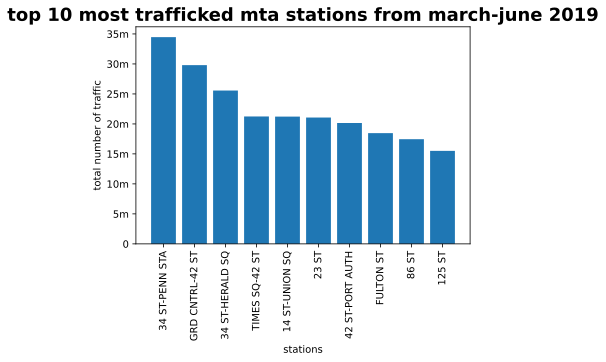

In [55]:
plt.bar(x=station_totals['STATION'][:10], height=station_totals['TOTAL_TRAFFIC'][:10])

plt.title("top 10 most trafficked mta stations from march-june 2019", fontsize=18, weight="bold")
plt.xlabel('stations')
plt.ylabel('total number of traffic')

plt.xticks(rotation=90)
total_y = [0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000]
total_label_y = ["0","5m", "10m", "15m", "20m", "25m", "30m", "35m"]
plt.yticks(total_y, total_label_y);

plt.savefig('top10stations.png', bbox_inches="tight")

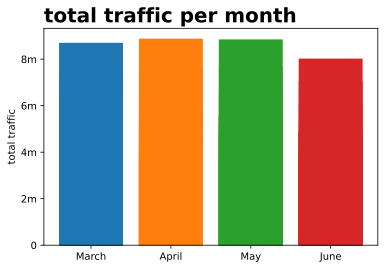

In [56]:
for i, group in station_monthly[((station_monthly['STATION'] =='34 ST-PENN STA') | (station_monthly['STATION'] == 'GRD CNTRL-42 ST') | 
               (station_monthly['STATION'] == '34 ST-HERALD SQ') | (station_monthly['STATION'] == '14 ST-UNION SQ') | 
               (station_monthly['STATION'] =='TIMES SQ-42 ST') | (station_monthly['STATION'] == '23 ST') | 
               (station_monthly['STATION'] == '42 ST-PORT AUTH') | (station_monthly['STATION'] == 'FULTON ST') | 
               (station_monthly['STATION'] =='86 ST') | (station_monthly['STATION'] == '125 ST') | 
               (station_monthly['STATION'] == 'CANAL ST'))].groupby('MONTH'):
    plt.bar(group['MONTH'], group['TOTAL_TRAFFIC'])
    
plt.title("total traffic per month", fontsize=20, weight="bold", loc="left")
plt.ylabel('total traffic')
ticks_x = [3, 4, 5, 6]
label = ["March", "April", "May", "June"]
plt.xticks(ticks_x, label);
month_y = [0, 2000000, 4000000, 6000000, 8000000]
month_label_y = ["0","2m", "4m", "6m", "8m"]
plt.yticks(month_y, month_label_y);

plt.savefig('monthtotals.png', bbox_inches="tight")



In [57]:
daily_entries_exits_plot = mta_entries_exits.groupby(["DATE"])[['DAILY_ENTRIES',"DAILY_EXITS"]].sum()

In [58]:
daily_entries_exits_plot

,DAILY_ENTRIES,DAILY_EXITS
DATE,,
03/01/2019,5842322.0,4561420.0
03/02/2019,2992200.0,2534672.0
03/03/2019,2440735.0,2147659.0
03/04/2019,4520844.0,3564624.0
03/05/2019,6014022.0,4822195.0
...,...,...
06/24/2019,5667540.0,4484284.0
06/25/2019,5850637.0,4615468.0
06/26/2019,6160356.0,4898619.0


In [59]:
#N = 2

#ind = np.arange(N)
#width = 0.35       
#plt.barh(ind, daily_entries_exits_plot.DAILY_ENTRIES, width, label='Entries')
#plt.barh(ind + width, daily_entries_exits_plot.DAILY_EXITS, width, label='Exits')

#plt.title('Total Entries and Exits by Day')
#plt.xyticks(ind + width / 2, daily_entries_exits_plot.DATE)
#plt.legend(loc='best')


In [60]:
plot_stats = mta_entries_exits.groupby("MONTH")['DAILY_ENTRIES','DAILY_EXITS'].agg([np.mean,np.std,np.median]).reset_index()

<ipython-input-60-88389d96b637>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_stats = mta_entries_exits.groupby("MONTH")['DAILY_ENTRIES','DAILY_EXITS'].agg([np.mean,np.std,np.median]).reset_index()


In [61]:
plot_stats

MONTH DAILY_ENTRIES                     DAILY_EXITS                    
                 mean          std median        mean          std median
0     3   1021.581304   994.953216  770.0  814.430353  1326.124117  489.0
1     4   1065.386727  1021.618945  817.0  852.654585  1467.071802  525.0
2     5   1071.473182  1034.577359  816.0  861.496904  1545.358054  528.0
3     6   1059.216590  1028.202368  810.0  893.028645  1977.713077  526.0